<a href="https://colab.research.google.com/github/iceman011/mydeeplearning/blob/master/ez_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import time
from datetime import datetime as dt
import datetime
import os
import pdb
import sys
import torchvision.models as pretrained_models

import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
  
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from collections import OrderedDict

from torch import optim
import itertools
#!/usr/bin/env python3
import mmap
import re
from itertools import dropwhile, product

import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers,output_classes,transform,dataset, drop_p=0.5,lr =0.001, train_on_gpu=False,network_type ='normal'):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        if train_on_gpu:
          # check if CUDA is available
          self.train_on_gpu = torch.cuda.is_available()

        if not self.train_on_gpu:
            print('CUDA is not available.  Using CPU ...')
        else:
            print('CUDA is available!  Using GPU ...')
        
        if(network_type == 'normal'):    
          self.input_size = input_size
          
          # Input to a hidden layer
          self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
          
          # Add a variable number of more hidden layers
          layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
          self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
          
          self.output = nn.Linear(hidden_layers[-1], output_size)
          
          self.dropout = nn.Dropout(p=drop_p)

        else:
          self.init_pre_trained_model(hidden_layers,network_type,output_size)

        self.output_size = output_size
        self.learning_rate = lr
        self.drop_ratio = drop_p
        self.output_classes = output_classes
        self.transform=transform
        self.dataset=dataset

        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        if(self.network_type == 'normal'):
          for each in self.hidden_layers:
              x = F.relu(each(x))
              x = self.dropout(x)
        else:
          x = self.classifier(x)
          
        x = self.output(x)
        return F.log_softmax(x, dim=1)

    def init_pre_trained_model(self,hidden_layers,network_type,output_size):

        if ( network_type == 'alexnet'):
            model = pretrained_models.alexnet(pretrained=True)
            self.input_size = model.classifier[1].in_features
        elif ( network_type == 'vgg11'):
            model = pretrained_models.vgg11(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg11_bn'):
            model = pretrained_models.vgg11_bn(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg13'):
            model = pretrained_models.vgg13(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg13_bn'):
            model = pretrained_models.vgg13_bn(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg16'):
            model = pretrained_models.vgg16(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg16_bn'):
            model = pretrained_models.vgg16_bn(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg19'):
            model = pretrained_models.vgg19(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'vgg19_bn'):
            model = pretrained_models.vgg19_bn(pretrained=True)
            self.input_size = model.classifier[0].in_features
        elif ( network_type == 'resnet18'):
            model = pretrained_models.resnet18(pretrained=True)
            self.input_size = model.fc.in_features
        elif ( network_type == 'resnet34'):
            model = pretrained_models.resnet34(pretrained=True)
            self.input_size = model.fc.in_features
        elif ( network_type == 'resnet50'):
            model = pretrained_models.resnet50(pretrained=True)
            self.input_size = model.fc.in_features
        elif ( network_type == 'resnet101'):
            model = pretrained_models.resnet101(pretrained=True)
            self.input_size = model.fc.in_features
        elif ( network_type == 'resnet152'):
            model = pretrained_models.resnet152(pretrained=True)
            self.input_size = model.fc.in_features
        elif ( network_type == 'squeezenet1_0'):
            model = pretrained_models.squeezenet1_0(pretrained=True)
            self.input_size = 512
        elif ( network_type == 'squeezenet1_1'):
            model = pretrained_models.squeezenet1_1(pretrained=True)
            self.input_size = 512
        elif ( network_type == 'densenet121'):
            model = pretrained_models.densenet121(pretrained=True)
            self.input_size = model.classifier.in_features
        elif ( network_type == 'densenet169'):
            model = pretrained_models.densenet169(pretrained=True)
            self.input_size = model.classifier.in_features
        elif ( network_type == 'densenet161'):
            model = pretrained_models.densenet161(pretrained=True)
            self.input_size = model.classifier.in_features
        elif ( network_type == 'densenet201'):
            model = pretrained_models.densenet201(pretrained=True)
            self.input_size = model.classifier.in_features
        elif ( network_type == 'inception_v3'):
            model = pretrained_models.inception_v3(pretrained=True)
            self.input_size = model.fc.in_features

            
        #print(model)
        # here we get all the modules(layers) before the fc layer at the end
        # note that currently at pytorch 1.0 the named_children() is not supported
        # and using that instead of children() will fail with an error
        self.features = nn.ModuleList(model.children())[:-1]

        # Now we have our layers up to the fc layer, but we are not finished yet 
        # we need to feed these to nn.Sequential() as well, this is needed because,
        # nn.ModuleList doesnt implement forward() 
        # so you cant do sth like self.features(images). Therefore we use 
        # nn.Sequential and since sequential doesnt accept lists, we 
        # unpack all the items and send them like this
        self.features = nn.Sequential(*self.features)

        # now lets add our new layers 
        #in_features = model.fc.in_features

        hidden_layers = [item for item in hidden_layers]
        hidden_layers.insert(0,self.input_size)

        self.hidden_layers = hidden_layers
        self.network_type = network_type

        self.classifier, self.output = self.make_dynamic_layers(hidden_layers,output_size)
        
        # Freeze parameters so we don't backprop through them
        for param in model.parameters():
            param.requires_grad = False

    def make_dynamic_layers(self,layers,n_classes):
        layers_block = nn.Sequential(*[
                                    nn.Sequential(
                                        nn.Linear(in_f, out_f),
                                        nn.ReLU(),
                                        nn.Dropout()
                                        ) 
                          for in_f, out_f in zip(layers, layers[1:])])
        
        output = nn.Linear(layers[-1], n_classes)
        
        return layers_block,output

"""
class PreTrainenModels(nn.Module):
      
      def __init__(self, input_size, output_size, hidden_layers,output_classes,transform,dataset, drop_p=0.5,lr =0.001, train_on_gpu=False,network_type ='normal'):
        
        super().__init__()
        
        if ( network_type == 'resnet18'):
          #assert input_size == 1024 ,  'input features of pre-trained networks must bet 1024'
          model = pretrained_models.resnet18(pretrained=True)
          input_size = model.fc.in_features
          
        #print(model)
        # here we get all the modules(layers) before the fc layer at the end
        # note that currently at pytorch 1.0 the named_children() is not supported
        # and using that instead of children() will fail with an error
        self.features = nn.ModuleList(model.children())[:-1]

        # Now we have our layers up to the fc layer, but we are not finished yet 
        # we need to feed these to nn.Sequential() as well, this is needed because,
        # nn.ModuleList doesnt implement forward() 
        # so you cant do sth like self.features(images). Therefore we use 
        # nn.Sequential and since sequential doesnt accept lists, we 
        # unpack all the items and send them like this
        self.features = nn.Sequential(*self.features)

        # now lets add our new layers 
        in_features = model.fc.in_features

        # from now, you can add any kind of layers in any quantity!  
        # Here I'm creating two new layers 
        #self.fc0 = nn.Linear(in_features, 256)
        #self.fc0_bn = nn.BatchNorm1d(256, eps = 1e-2)
        #self.fc1 = nn.Linear(256, output_size)
        #self.fc1_bn = nn.BatchNorm1d(output_size, eps = 1e-2)
        
        # initialize all fc layers to xavier
        #for m in self.modules():
        #    if isinstance(m, nn.Linear):
        #        torch.nn.init.xavier_normal_(m.weight, gain = 1)
        
        hidden_layers = [item for item in hidden_layers]
        hidden_layers.insert(0,in_features)

        self.hidden_layers = hidden_layers
        
        self.classifier, self.output = classifier_block(hidden_layers,output_size) #MyPreTrainedClassifier(hidden_layers,output_size)
        
        #self.model = model
        #self.model.last_linear= self.classifier
        #self.output = nn.Linear(hidden_layers[-1], output_size)
        #self.dropout = nn.Dropout(p=drop_p)

        self.classifier = nn.Sequential(OrderedDict([
                                  ('fc1', nn.Linear(in_features, 500)),
                                  ('relu', nn.ReLU()),
                                  ('fc2', nn.Linear(500, output_size)),
                                  ('output', nn.LogSoftmax(dim=1))
                                  ]))
           
        #model.classifier = classifier

        # Freeze parameters so we don't backprop through them
        for param in model.parameters():
            param.requires_grad = False

        if train_on_gpu:
          # check if CUDA is available
          self.train_on_gpu = torch.cuda.is_available()

        if not self.train_on_gpu:
            print('CUDA is not available.  Using CPU ...')
        else:
            print('CUDA is available!  Using GPU ...')
            
        
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = lr
        self.drop_ratio = drop_p
        self.output_classes = output_classes
        self.transform=transform
        self.dataset=dataset
        self.network_type= network_type


      def get_dense_net(self):        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = None

        if ( self.network_type == 'densenet121'):
          assert self.input_size == 1024 ,  'input features of pre-trained networks must bet 1024'
          model = pretrained_models.densenet121(pretrained=True)

        # Freeze parameters so we don't backprop through them
        for param in model.parameters():
            param.requires_grad = False
            
        model.classifier = nn.Sequential(nn.Linear(self.input_size, 256),
                                        nn.ReLU(),
                                        nn.Dropout(self.drop_ratio),
                                        nn.Linear(256, self.output_size),
                                        nn.LogSoftmax(dim=1))

        criterion = nn.NLLLoss()

        # Only train the classifier parameters, feature parameters are frozen
        optimizer = optim.Adam(model.classifier.parameters(), lr=self.learning_rate)

        model.to(device)
        
        return model , criterion , optimizer


      def forward(self, x):
        #return self.model(x)
       # now in forward pass, you have the full control, 
       # we can use the feature part from our pretrained model  like this
        #x = self.features(x)

        # since we are using fc layers from now on, we need to flatten the output.
        # we used the avgpooling but we still need to flatten from the shape (batch, 1,1, features)
        # to (batch, features) so we reshape like this. input_imgs.size(0) gives the batchsize, and 
        # we use -1 for inferring the rest
        #output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        #output = self.fc0_bn(F.relu(self.fc1(output)))
        #output = self.fc1_bn(F.relu(self.fc1(output)))
        
        x = self.classifier(x)

        #x = F.relu(self.classifier.fc1(x))
        #x = self.dropout(x)
        #x = F.relu(self.classifier.fc2(x))
        #x = self.dropout(x)
        #x = self.classifier.output(x)
        x = self.output(x)

        return F.log_softmax(x, dim=1)
        #return x




class MyPreTrainedClassifier(nn.Module):

    def __init__(self, classifier_sizes, n_classes):
        super().__init__()
        self.classifier = nn.Sequential(*[classifier_block(in_f, out_f) 
                       for in_f, out_f in zip(classifier_sizes, classifier_sizes[1:])])
        self.output = nn.Linear(classifier_sizes[-1], n_classes)

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

    def forward_last(self, x):
      x = self.classifier(x)
      x = self.output(x)

      for each in self.hidden_layers:
        x = F.relu(each(x))
        x = self.dropout(x)
        x = self.output(x)
      
      return F.log_softmax(x, dim=1)

"""

######################    
# LOADING DATA #
######################
def LoadData(datasetName,batch_size=20,valid_size = 0.2,network_type='normal'):
      
    # number of subprocesses to use for data loading
    num_workers = 0

    # convert data to torch.FloatTensor
    #transform = transforms.ToTensor()

    # convert data to a normalized torch.FloatTensor
    transform = None
    train_data= None
    valid_data= None
    test_data=None
    classes=None
    normalize = None

    if network_type != 'normal' :
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    elif network_type == 'normal' and datasetName == 'MINST' :
      normalize = transforms.Normalize((0.5, ), (0.5, ))
    elif network_type == 'normal' and datasetName == 'CIFAR' :
      normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    if(datasetName == 'MINST'):
       # convert data to a normalized torch.FloatTensor
      train_transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          #transforms.RandomRotation(10),
          transforms.CenterCrop(224),          
          transforms.ToTensor(),
          normalize
          ])

      valid_transform = transforms.Compose([
          transforms.ToTensor(),
          normalize
          ])

      # choose the training and test datasets
      train_data = datasets.MNIST(root='data', train=True,
                                        download=True, transform=train_transform)
      valid_data = datasets.MNIST(root='data', train=True,
                                        download=True, transform=valid_transform)
      test_data = datasets.MNIST(root='data', train=False,
                                        download=True, transform=valid_transform)
      # specify the image classes
      classes = ['1', '2', '3', '4', '5',
           '6', '7', '8', '9', '10']
    elif(datasetName == 'CIFAR'):
      
      # convert data to a normalized torch.FloatTensor
      valid_transform = transforms.Compose([
          transforms.ToTensor(),
          normalize
          ])
      
      train_transform = transforms.Compose([
          transforms.RandomHorizontalFlip(), # randomly flip and rotate
          transforms.RandomRotation(10),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize
          ])
      
      # choose the training and test datasets
      train_data = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=train_transform)
      valid_data = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=valid_transform)
      test_data = datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=valid_transform)
      # specify the image classes
      classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)
    return train_loader , valid_loader ,test_loader ,classes , transform



#############################
# VALIDATE MODEL
############################
def validation(model, validationloader, criterion):
    accuracy = 0
    validation_loss = 0
    validate_start_time = time.time()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : ','Starting Validation....')

    with torch.no_grad():    
      # move tensors to GPU if CUDA is available
      if model.train_on_gpu:
        model.cuda()

      for images, labels in validationloader:

          if model.train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
          
          images = images.resize_(images.size()[0], model.input_size)

          output = model.forward(images)
          validation_loss += criterion(output, labels).item()

          ## Calculating the accuracy 
          # Model's output is log-softmax, take exponential to get the probabilities
          ps = torch.exp(output)
          # Class with highest probability is our predicted class, compare with true label
          #equality = (labels.data == ps.max(1)[1])
          # Accuracy is number of correct predictions divided by all predictions, just take the mean
          #accuracy += equality.type_as(torch.FloatTensor()).mean()


        
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))      
        
      validation_loss = validation_loss/len(validationloader)
      accuracy = 100. * accuracy/len(validationloader)
    
    print('Finished Validation In ',datetime.timedelta(seconds = time.time() - validate_start_time) )
    return validation_loss, accuracy

#############################
# TEST MODEL
############################
def test(model,test_loader,criterion,checkpoint,outputfilepath,batch_size,override_checkpoint):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(model.output_size))
    class_total = list(0. for i in range(model.output_size))
    test_start_time = time.time()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Testing....')
    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    with torch.no_grad():    
      model.eval()
      # iterate over test data
      for data, target in test_loader:
          # move tensors to GPU if CUDA is available
          if model.train_on_gpu:
              data, target = data.cuda(), target.cuda()
          
          # Flatten images into a 784 long vector
          data.resize_(data.size()[0], model.input_size)

          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update test loss 
          test_loss += loss.item()*data.size(0)
          # convert output probabilities to predicted class
          _, pred = torch.max(output, 1)    
          # compare predictions to true label
          correct_tensor = pred.eq(target.data.view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not model.train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
          for i in range(batch_size):
              label = target.data[i]
              class_correct[label] += correct[i].item()
              class_total[label] += 1

      # average test loss
      print('Finished Testing during ',datetime.timedelta(seconds=time.time() - test_start_time))
      test_loss = test_loss/len(test_loader.dataset)
      print('Test Loss: {:.6f}\n'.format(test_loss))
      
      test_checkpoint = dict()

      if(override_checkpoint):
        checkpoint.update({'TestLoss': test_loss})
      else :
        test_checkpoint.update({'TestLoss': test_loss})

      for i in range(model.output_size):
          if class_total[i] > 0:
            current_key  = 'Test Accuracy of '+model.output_classes[i]
            current_val = '{:.3f}% ({}/{})'.format(100 *( class_correct[i] / class_total[i]),
                  np.sum(class_correct[i]), np.sum(class_total[i]))
            ele={current_key:current_val}
            if(override_checkpoint):
              checkpoint.update(ele)
              print(current_key,current_val)
            else:
              test_checkpoint.update(ele)


          """else:
              print('Test Accuracy of %5s: N/A (no training examples)' % (model.output_classes[i]))
          """

      current_key = 'Test Accuracy (Overall): '#.format(100. * np.sum(class_correct) / np.sum(class_total))
      current_val = '{:.3f}% ({}/{})'.format(100 * (np.sum(class_correct) / np.sum(class_total)),
          np.sum(class_correct), np.sum(class_total) )
      ele={current_key:current_val}
      if(override_checkpoint):
        checkpoint.update(ele)      
        print(current_key,current_val)
      else:
        test_checkpoint.update(ele)
        test_checkpoint.update({'Detailed ':checkpoint})

    
    #model.train()
    if(override_checkpoint):
      print('Overriding Checkpoint')
      torch.save(checkpoint,outputfilepath)

    return checkpoint , test_checkpoint

#############################
# TRAIN MODEL
############################
def train(model, trainloader, validationloader, criterion, optimizer, uploadToGDrive,checkpointPath,PreviousCheckPointId,
          PreviousValidationLoss,start_time,exp_id,epochs=5, print_every=40):
    # monitor training loss    
    steps = 0    
    #start_time = time.time()
    #dateTimeObj = datetime.now()
    #start_time_timestamp = './results/'+dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    #start_time_timestamp = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
    train_losses, valid_losses = [], []
    checkpoint = dict()

    # move tensors to GPU if CUDA is available
    if model.train_on_gpu:
      model.cuda()

    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Training using Model Parameters \n '+str(model)+' \n from PreviousModel '+ PreviousCheckPointId + ' with validationLoss '+ str(PreviousValidationLoss) )
    valid_loss_min = PreviousValidationLoss #np.Inf # set initial "min" to infinity

    for e in range(epochs):        
        train_loss = 0.0
        valid_loss = 0.0
        epoch_start_time = time.time()

        print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Starting Training of Epoch'+str(e)  )
        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for images, labels in trainloader:
            steps += 1
            
            # move tensors to GPU if CUDA is available
            if model.train_on_gpu:
              images, labels = images.cuda(), labels.cuda()

            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], model.input_size)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss = train_loss/len(trainloader.sampler)
        train_losses.append(train_loss)
        ######################    
        # validate the model #
        ######################
        # Model in inference mode, dropout is off
        model.eval()
        print(' Finished Training of Epoch '+str(e),' In ',datetime.timedelta(seconds = time.time() - epoch_start_time) )

        # Turn off gradients for validation, will speed up inference
        with torch.no_grad():
            valid_loss, accuracy = validation(model, validationloader, criterion)
        
        valid_losses.append(valid_loss)

        print('{} : Epoch: {} \tTraining Loss: {:.9f} \tValidation Loss: {:.9f} \tAccuracy : {:.6f}'.format(
            dt.now().strftime("%d_%b_%Y_%H_%M_%S"),
            e, 
            train_loss,
            valid_loss,
            accuracy
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.9f} --> {:.9f} ,)  Accuracy: {:.6f}  TimeElapsed: {}.  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            accuracy,
            (datetime.timedelta(seconds = time.time() - start_time))))
            
            checkpoint = {'InputSize': model.input_size,
                  'OutputSize': model.output_size,
                  'HiddenLayers': [each.out_features for each in model.hidden_layers] if model.network_type == 'normal' else model.hidden_layers[1:], 
                  'LearningRate':model.learning_rate,
                  'DropRatio':model.drop_ratio,
                  'TrainingLoss' :train_loss,
                  'ValidationLoss':valid_loss,
                  'ValidationAccuracy':accuracy,
                  'ElapsedTime': datetime.timedelta(seconds = time.time() - start_time),
                  'Dataset':model.dataset,
                  'LastEpoch': e,
                  'PreviousCheckPoint': PreviousCheckPointId,
                  'GPUState': model.train_on_gpu,                  
                  'OutputFolder' : (exp_id+'/'+ model.network_type) if model.network_type != 'normal' else exp_id,
                  'CheckPointTimestamp': dt.now().strftime("%d_%b_%Y_%H_%M_%S"), #time.time(),
                  'OutputFilePrefix' : 'checkpoint_',
                  'OutputClasses': model.output_classes,
                  'NetworkType' : model.network_type,
                  'Transforms': model.transform,
                  'TrainingLosses' :train_losses,
                  'ValidationLosses':valid_losses,
                  'StateDictionay': model.state_dict()}
            
            save_model(checkpoint,uploadToGDrive,checkpointPath)
            valid_loss_min = valid_loss
        
        sys.stdout.flush()

    return train_losses , valid_losses , checkpoint


#############################
# SAVE MODEL TO GOOGLE DRIVE
############################
def save_model(checkpoint,uploadToGDrive,checkpointPath):
  
  file_path = ''
  if(uploadToGDrive):
    drive.mount('/content/gdrive')
    file_path = checkpointPath+checkpoint['OutputFolder']
    if not os.path.exists(file_path):
      os.makedirs(file_path)      
    #path = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch'])+'.pt'
    print('Saving Model to ',file_path +'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
    torch.save(checkpoint, file_path +'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
  else:
    file_path=checkpointPath+checkpoint['OutputFolder']
    if not os.path.exists(file_path):
      os.makedirs(file_path)
    print('Saving Model to ',file_path+'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')
    torch.save(checkpoint, file_path+'/'+checkpoint['OutputFilePrefix']+str(checkpoint['CheckPointTimestamp'])+'_'+str(checkpoint['LastEpoch'])+'.pt')


###########################
# SKIP CERTAIN ENTERIES FROM ITERTOOLS.PRODUCT
#####################33
def resume(iterable, sentinel):
    yield from dropwhile(lambda x: x != sentinel, iterable)

#############################
# LOAD LAST EXPERIMENT PARAMS
##################################
def load_last_exp_param(logPath,checkpointPath):

  #with open(checkpointPath+'/3-3-2020.txt') as f:
  #    total = f.read()
  #    print( total.count('Starting New') )
      
  f = open(logPath, 'r')
  content = f.read()

  network_type = re.findall('Network Type: \{(.+?)\}', content)
  network_type = network_type[len(network_type)-1]

  hidden_layers = re.findall('hidden_layers: \{(.+?)\}', content)
  hidden_layers = int(hidden_layers[len(hidden_layers)-1])

  hidden_layer_width = re.findall('hidden_layer_width: \{(.+?)\}', content)
  hidden_layer_width = hidden_layer_width[len(hidden_layer_width)-1]

  Learning_rate = re.findall('Learning_Rate: \{(.+?)\}', content)
  Learning_rate = float(Learning_rate[len(Learning_rate)-1])

  drop_ratio = re.findall('drop_ratio: \{(.+?)\}', content)
  drop_ratio = float(drop_ratio[len(drop_ratio)-1])
  prev_valid_loss = np.Inf
  return_checkpoint = None
  return_model = None

  #for filename in os.listdir(checkpointPath):
  for root, dirs, files in os.walk(checkpointPath):
    for filename in files:
      model , checkpoint , filepath = load_checkpoint(root,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')],load_model=True)
      if( float(checkpoint['ValidationLoss']) < prev_valid_loss ):
        prev_valid_loss = checkpoint['ValidationLoss']
      
      
      #pdb.set_trace()
      hidden_layer_width_local = hidden_layer_width.strip()
      hidden_layer_width_local = hidden_layer_width_local[1:len(hidden_layer_width_local)-1]
      hidden_layer_width_local = list(map(int, hidden_layer_width_local.split(',')))

      if( network_type == checkpoint['NetworkType'] and hidden_layer_width_local == checkpoint['HiddenLayers'] and float(checkpoint['ValidationLoss']) <= prev_valid_loss ):
        print(' Found Matching Checkpoint with Last Experiement Parame ValidationLoss:{} hidden_layers:{}  hidden_layer_width:{} Learning_rate:{} drop_ratio:{} network_type:{} '.format(checkpoint['ValidationLoss'],hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,checkpoint['NetworkType']))
        return_checkpoint = checkpoint
        return_model = model
        prev_valid_loss = checkpoint['ValidationLoss']
        #return checkpoint,model,hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,prev_valid_loss

  if( not bool(return_checkpoint)): 
    print(' Not Found Matching Checkpoint with Last Experiement Parameters hidden_layers:{}  hidden_layer_width:{} Learning_rate:{} drop_ratio:{} network_type:{} '.format(hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,network_type))    

  return return_checkpoint,return_model,hidden_layers,hidden_layer_width,Learning_rate,drop_ratio,prev_valid_loss,network_type


################################
# TUNE NETWORK LAYERS AND NO. OF NODES
##################################
def tune_train_network(dataset,epochs,resumeExp=False,resume_logPath='',resume_checkpointPath='',network_type='normal'):

  start_time = time.time()
  dateTimeObj = dt.now()
  exp_id = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")

  #How many samples loaded per batch
  batch_size = 20
  # percentage of training set to use as validation
  valid_size = 0.2
  #dataset = 'MINST'
  checkpointPath = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'
  #checkpointPath = f'./results/'+dataset+'/'

  #train_loader =None
  #valid_loader =None
  global_train_loss = None
  global_valid_loss = None
  print('Starting Tunning ...')
  
  global_train_loss , global_valid_loss = plotLossTrendAll(resume_checkpointPath,True,global_train_loss,global_valid_loss)

  #Load Data
  drive.mount('/content/gdrive')
  train_loader , valid_loader ,test_loader , classes , transform = LoadData(dataset,batch_size,valid_size,network_type)

  nodes_per_layer =  [2048, 1024, 512, 256, 128, 64, 32]
  full_learning_rates= [0.1, 0.01, 0.0001, 0.001]
  full_drop_ratios= [0.8, 0.5, 0.3, 0.1]
  full_pre_trained_models = ['alexnet','vgg11','vgg11_bn','vgg13','vgg13_bn','vgg16','vgg16_bn','vgg19','vgg19_bn',
                             'resnet18','resnet34','resnet50','resnet101','resnet152',
                             'squeezenet1_0','squeezenet1_1',
                             'densenet121','densenet169','densenet161','densenet201',
                             'inception_v3'
                            ]
  learning_rates = None
  drop_ratios = None
  pre_trained_models = None
  PreviousValidationLoss= np.Inf
  max_hidden_layers = 2
  iter_hidden_layer_nodes = None
  iter_hidden_layer_nodes_list = None
  model = None
  resume_checkpoint = None

  if(resumeExp):
    print(dt.now().strftime("%d_%b_%Y_%H_%M_%S")+' : Resuming Experiment With New ID ',exp_id )
    resume_checkpoint,model,resum_hidden_layers,resume_hidden_layer_width,resume_Learning_rate,resume_drop_ratio,resume_prev_valid_loss,resume_network_type =  load_last_exp_param(resume_logPath,resume_checkpointPath)
    max_hidden_layers = resum_hidden_layers  

    learning_rates = full_learning_rates[full_learning_rates.index(resume_Learning_rate):]
    drop_ratios = full_drop_ratios[full_drop_ratios.index(resume_drop_ratio):]
    pre_trained_models = full_pre_trained_models[full_pre_trained_models.index(resume_network_type):]

    PreviousValidationLoss = resume_prev_valid_loss
    checkpointPath = resume_checkpointPath

      #iter_hidden_layer_nodes = resume(itertools.product(nodes_per_layer, repeat=hidden_layers+1), resume_checkpoint['HiddenLayers'])      
    #if(bool(resume_checkpoint)):
    #  model , resume_checkpoint , filepath = load_checkpoint(checkpointPath,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')])
      

  global_counter = 0
  #VARY HIDDEN LAEYERS
  for hidden_layers in range(max_hidden_layers,0,-1):
    #VARY HIDDEN LAYER NODES/WIDTH
    if(resumeExp):
      
      iter_hidden_layer_nodes = itertools.product(nodes_per_layer, repeat= hidden_layers)
      iter_hidden_layer_nodes_list = [item for item in iter_hidden_layer_nodes]
      resume_hidden_layer_width = resume_hidden_layer_width[1:len(resume_hidden_layer_width)-1]
      
      #pdb.set_trace()
      resume_hidden_layer_width = resume_hidden_layer_width[1:len(resume_hidden_layer_width)-1]
      resume_hidden_layer_width_list = tuple(list(map(int, resume_hidden_layer_width.split(','))))
      iter_hidden_layer_nodes_list = iter_hidden_layer_nodes_list[iter_hidden_layer_nodes_list.index(resume_hidden_layer_width_list):]
      
      print('Resume ValidationLoss ',PreviousValidationLoss,'Resume Learning Rate Array ',learning_rates ,' Resume Drop Ratio List ',drop_ratios , ' Resume Hidden Nodes List with Size :',len(iter_hidden_layer_nodes_list) , ' Starting From :',iter_hidden_layer_nodes_list[0],' resume Pretrained Model with Size: ',len(pre_trained_models), ' Starting From: ',pre_trained_models[0] )
    else:      
      iter_hidden_layer_nodes = itertools.product(nodes_per_layer, repeat=hidden_layers)
      iter_hidden_layer_nodes_list = [item for item in iter_hidden_layer_nodes]
    for hidden_layer in iter_hidden_layer_nodes_list:
      #VARY LEARNING RATE
      if( not resumeExp):
        learning_rates = full_learning_rates
      for lr in learning_rates :
        #VARY DROP RATIO
        if( not resumeExp):
          drop_ratios = full_drop_ratios
        for drop_ratio in drop_ratios :
          if( not resumeExp):
            pre_trained_models = full_pre_trained_models
          for pre_trained_model in pre_trained_models :
            print('Start Global Counter: '+str(global_counter)+' Network Type:'+pre_trained_model+' EXP-ID:'+exp_id+'  DurationSinceStart :',datetime.timedelta(seconds = time.time() - start_time),' with hidden_layers:',hidden_layers,' hidden_layer_width:',hidden_layer ,' Learning_Rate:',lr, ' drop_ratio:',drop_ratio)
            #model = Network(784, 10, [first_layer, second_layer, third_layer ],classes,transform,dataset, lr=0.001,train_on_gpu=True)

            if( not bool(resume_checkpoint) or not resumeExp ):
              #intput_size = (28*28) if network_type == 'normal' and dataset == 'MINST' else (32*32*3) if network_type == 'normal' and dataset == 'CIFAR' else 1024 # 1024 is defult for pretrained networks
              input_size = 0
              if network_type == 'normal' and dataset == 'MINST':
                input_size = (28*28) 
              elif network_type == 'normal' and dataset == 'CIFAR' :
                input_size = (32*32*3)  
              #elif network_type != 'normal' :
              #input_size = 1024 # 1024 is defult for pretrained networks

              #if network_type == 'normal':
              model = Network(input_size, 10, hidden_layer ,classes,transform,dataset,drop_p=drop_ratio,lr =lr,train_on_gpu=True,network_type=pre_trained_model)
              #else:
              #  model = PreTrainenModels(input_size, 10, hidden_layer ,classes,transform,dataset,drop_p=drop_ratio,lr =lr,train_on_gpu=True,network_type=network_type)

            criterion = nn.NLLLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

              #if(dataset == 'MINST'):
              #  model = Network(784, 10, hidden_layer ,classes,transform,dataset,drop_p=drop_ratio,lr =lr,train_on_gpu=True,network_type=network_type)
              #else:
              #  model = Network((32*32*3), 10, hidden_layer ,classes,transform,dataset,drop_p=drop_ratio,lr =lr,train_on_gpu=True,network_type=network_type)

            #Upload checkpoint to local drive
            #train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, False,checkpointPath,PreviousCheckPointId,PreviousValidationLoss,epochs=100)

            
            train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, True,checkpointPath,'',PreviousValidationLoss,start_time,exp_id,epochs=epochs)
            if( bool(checkpointt) and checkpointt['ValidationLoss'] < PreviousValidationLoss ):
              PreviousValidationLoss = checkpointt['ValidationLoss']
            
            print('Finished Global Counter: '+str(global_counter)+' %Network Type: {'+pre_trained_model+'}% EXP-ID : '+exp_id+'  DurationSinceStart :',datetime.timedelta(seconds = time.time() - start_time),' with %hidden_layers: {',hidden_layers,'}% %hidden_layer_width: {',hidden_layer ,'}% %Learning_Rate: {',lr, '}% %drop_ratio: {',drop_ratio,'}%')
            global_counter+= 1

            #Plot current experiement training vs validation losses
            plotLossTrend(train_lossess,valid_lossess, mode='Single')

            #Plot global training vs validation losses
            key = dataset + '_' + exp_id + '_' + (str(checkpointt['LastEpoch']) if bool(checkpointt) else str(epochs))            
            
            # get minimal loss here , as may be during certain experiment its loss is not less than global loss
            min_loss = np.Inf
            for curr_loss in train_lossess:
              if(curr_loss < min_loss):
                min_loss = curr_loss
            ele = {key: min_loss}
            global_train_loss.append(ele)
            

            ele = {}
            min_loss = np.Inf
            for curr_loss in valid_lossess:
              if(curr_loss < min_loss):
                min_loss = curr_loss
            ele = {key: min_loss}
            global_valid_loss.append(ele)

            global_train_loss , global_valid_loss = plotLossTrendAll(resume_checkpointPath,False,global_train_loss,global_valid_loss)
          
          #pdb.set_trace()
          resumeExp=False

#######################
# PLOT LOSS TREND OF TRAINING & VALIDATON OF ALL EXP
##############################3
def plotLossTrendAll(OutputFolder,init,train_loss,valid_loss):

    #OutputFolder = './results/'
    file_epoch = 0
    result_list=[]
    print('Starting Plotting Loss Trend Across All Experiements ....')
    training_loss=[]
    validation_loss=[]
    ele = dict()

    """
        for folder in os.listdir(OutputFolder):
          for filename in os.listdir(OutputFolder+folder):
            data = filename.split('_')
            #pdb.set_trace()
            print(data)
            file_epoch=int(data[1][:-3])

            model , checkpoint , filepath = load_checkpoint(OutputFolder+folder,OutputFilePrefix,False,file_epoch)
    """
    if(init):
      for root, dirs, files in os.walk(OutputFolder):
        for filename in files:
          model , checkpoint , filepath = load_checkpoint(root,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')],load_model=False)

          key = checkpoint['Dataset'] + '_' + checkpoint['OutputFolder'] + '_' + str(checkpoint['LastEpoch'])
          ele = {key: checkpoint['TrainingLoss']}
          training_loss.append(ele)
          
          ele = {}
          ele ={key: checkpoint['ValidationLoss']}
          validation_loss.append(ele)
    else:
      training_loss = train_loss
      validation_loss = valid_loss
        
    #print('Result List',result_list)
    plotLossTrend (training_loss,validation_loss,mode='Multiple')

    return training_loss,validation_loss
      

#############################
# PLOT TRAINING LOSS VS VALIDATION LOSS 
############################
def plotLossTrend(train_losses,validation_losses,test_losses=[],mode='Single'):
  #TRAINING LOSS DATA
  values = []
  labels = []
  
  if(mode !='Single'):
    for item in train_losses:    
      for key, value in item.items():
        values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
        labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
  else:
    for epoch in range(len(train_losses)):    
      values.append("{0:.5f}".format(train_losses[epoch])) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(epoch) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    #values = train_losses
    #labels = train_losses

  plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Training Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #VALIDATON LOSS
  values = []
  labels = []
  if(mode !='Single'):
    for item in validation_losses:   
      #pdb.set_trace() 
      for key, value in item.items():      
        values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
        labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
  else:
    for epoch in range(len(validation_losses)):    
      values.append("{0:.5f}".format(validation_losses[epoch])) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(epoch) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Validation Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))
  
  plt.xticks(rotation=90)
  #plt.show()

  #TEST LOSS
  values = []
  labels = []
  for item in test_losses:    
    for key, value in item.items():
      #pdb.set_trace()
      values.append("{0:.5f}".format(value)) #= train_losses[:1] #[7, 57, 121, 192, 123, 240, 546]
      labels.append(key) #= train_losses[:0] #['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

  if(bool(test_losses)):
    plt.title("Training vs Validation vs Testing")
  else:
    plt.title("Training vs Validation")
  if( mode == 'Single' ):
    plt.xlabel("Epochs")
  else:
    plt.xlabel("Expriements")

  #plt.figure(figsize = (12,12))   
  plt.plot(labels,values,label='Test Loss')
  for i,j in zip(labels,values):
      plt.annotate(str(j),xy=(i,j))

  plt.ylabel("Loss")  
  #plt.ylim((0,1.))

  plt.xticks(rotation=90)
  plt.legend()
  plt.show()
  #for i, v in enumerate(values):
  #    ax.text(i, v+25, "%d" %v, ha="center")
  #plt.ylim(-10, 595)

#############################
# LOAD CHECKPOINT
############################
def load_checkpoint(OutputFolder,OutputFilePrefix,max_epoch,exact_epoch,load_model=True):
    
    file_epoch = 0
    if(max_epoch):
      for filename in os.listdir(OutputFolder):
        data = filename.split('_')
        tmp=int(data[1][:-3])
        #print('data[1]',data[1],' tmp[:-3] ',tmp[:-3])
        if( file_epoch <= tmp ):
          file_epoch = tmp
    else:
      file_epoch=exact_epoch

    filepath = OutputFolder+'/'+OutputFilePrefix + str(file_epoch)+'.pt'
    print('Loading Checkpoint from '+filepath+'...')
    indent=1
    
    cpu_or_gpu = torch.cuda.is_available()
    checkpoint = None

    if not cpu_or_gpu :
      checkpoint = torch.load(filepath,map_location='cpu')
    else:
      checkpoint = torch.load(filepath)

    for key, value in checkpoint.items():
        if(key == 'StateDictionay'):
          continue
        print('\t' * indent + str(key),'\t' * (indent+1) + str(value))
        #print('\t' * (indent+1) + str(value))
    
    testmodel = None

    if(load_model ):
      testmodel = Network(    checkpoint['InputSize'],
                              checkpoint['OutputSize'],
                              checkpoint['HiddenLayers'],
                              checkpoint['OutputClasses'],
                              checkpoint['Transforms'],
                              checkpoint['Dataset'],
                              checkpoint['DropRatio'],
                              checkpoint['LearningRate'],
                              train_on_gpu=checkpoint['GPUState'],
                              network_type=checkpoint['NetworkType']
                      )
      testmodel.load_state_dict(checkpoint['StateDictionay'])
    """elif(load_model and checkpoint['NetworkType'] !='normal' ):
      testmodel = PreTrainenModels(    checkpoint['InputSize'],
                              checkpoint['OutputSize'],
                              checkpoint['HiddenLayers'],
                              checkpoint['OutputClasses'],
                              checkpoint['Transforms'],
                              checkpoint['Dataset'],
                              checkpoint['DropRatio'],
                              checkpoint['LearningRate'],
                              train_on_gpu=checkpoint['GPUState'],
                              network_type=checkpoint['NetworkType']
                      )
    
    print(testmodel.state_dict().keys())
    """


    return testmodel , checkpoint , filepath


def test_all_epochs(OutputFolder,test_loader,criterion,batch_size,OutputFilePrefix='checkpoint_'):

    #OutputFolder = './results/'
    file_epoch = 0
    result_list=[]
    print('Starting Test All Saved Epochs ....')
    trainig_loss=[]
    validation_loss=[]
    test_loss=[]
    ele = dict()

    """
        for folder in os.listdir(OutputFolder):
          for filename in os.listdir(OutputFolder+folder):
            data = filename.split('_')
            #pdb.set_trace()
            print(data)
            file_epoch=int(data[1][:-3])

            model , checkpoint , filepath = load_checkpoint(OutputFolder+folder,OutputFilePrefix,False,file_epoch)
    """
    #for filename in os.listdir(checkpointPath):
    for root, dirs, files in os.walk(OutputFolder):
      for filename in files:
        model , checkpoint , filepath = load_checkpoint(root,filename[:filename.rfind('_')+1],False,filename[filename.rfind('_')+1:filename.rfind('.')],load_model=True)

        checkpoint , checkpoint_test = test(model,test_loader,criterion,checkpoint,filepath,batch_size,False)

        print('Test Accuracy ',checkpoint_test['Test Accuracy (Overall): '])
        result_list.append(checkpoint_test)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['TrainingLoss'])
        key = checkpoint['Dataset'] + '_' + checkpoint['OutputFolder'] + '_' + str(checkpoint['LastEpoch'])
        ele = {key: checkpoint['TrainingLoss']}
        trainig_loss.append(ele)
        
        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint['ValidationLoss'])
        ele = {}
        ele ={key: checkpoint['ValidationLoss']}
        validation_loss.append(ele)

        #ele = [list() for f in range(1)] # We have Three Empty Rows
        #ele[0].append(checkpoint['Dataset']+'_'+checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch']))
        #ele[0].append(checkpoint_test['TestLoss'])
        ele = {}
        ele ={key: checkpoint_test['TestLoss']}
        test_loss.append(ele)
    
    #print('Result List',result_list)
    plotLossTrend (trainig_loss,validation_loss,test_loss)
    return result_list
      

#############################
# VISUALIZE ALL IMAGES IN BATCH
############################
def visualize_images_in_batch(loader,batch_size) :
    # obtain one batch of training images
		dataiter = iter(loader)
		images, labels = dataiter.next()
		images = images.numpy()

		# plot the images in the batch, along with the corresponding labels
		fig = plt.figure(figsize=(25, 4))
		for idx in np.arange(batch_size):
			ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
			ax.imshow(np.squeeze(images[idx]), cmap='gray')
			# print out the correct label for each image
			# .item() gets the value contained in a Tensor
			ax.set_title(str(labels[idx].item()))
		return images

#############################
# VISUALIZE ALL RGB IMAGES IN BATCH
############################
def visualize_rgb_images_in_batch(train_loader):
  # obtain one batch of training images
  dataiter = iter(train_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  # display 20 images
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      #imshow(images[idx])
      img = images[idx]
      img = img / 2 + 0.5  # unnormalize
      plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
      ax.set_title(classes[labels[idx]])



#############################
# VISUALIZE PIXEL OF AN IMAGE RETURN FROM PREV FUNCTION
############################
def visualize_image_pixels_value(image):

  img = np.squeeze(image)
  fig = plt.figure(figsize = (12,12)) 
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
      for y in range(height):
          val = round(img[x][y],2) if img[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center',
                      color='white' if img[x][y]<thresh else 'black')

def visualize_rgb_image_pixels_value(image):
  rgb_img = np.squeeze(image)
  channels = ['red channel', 'green channel', 'blue channel']

  fig = plt.figure(figsize = (36, 36)) 
  for idx in np.arange(rgb_img.shape[0]):
      ax = fig.add_subplot(1, 3, idx + 1)
      img = rgb_img[idx]
      ax.imshow(img, cmap='gray')
      ax.set_title(channels[idx])
      width, height = img.shape
      thresh = img.max()/2.5
      for x in range(width):
          for y in range(height):
              val = round(img[x][y],2) if img[x][y] !=0 else 0
              ax.annotate(str(val), xy=(y,x),
                      horizontalalignment='center',
                      verticalalignment='center', size=8,
                      color='white' if img[x][y]<thresh else 'black')

def visualize_test_results(model,test_loader,batch_size,RGB=False):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()

  # move model inputs to cuda, if GPU available
  if model.train_on_gpu:
      images = images.cuda()

  # Flatten images into a 784 long vector
  images.resize_(images.size()[0], model.input_size)

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not model.train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(batch_size):
      ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])

      image_cpu = images.cpu()[idx]
      image_cpu = image_cpu / 2 + 0.5  # unnormalize
      if(RGB):
        plt.imshow(np.transpose(image_cpu, (1, 2, 0)))  # convert from Tensor image
      else:
        ax.imshow(np.squeeze(image_cpu), cmap='gray')

      ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
############################# TEST TUNE NETWORK ####################################
import sys

"""
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
"""
def test_tune_train_network(dataset):    
  drive.mount("/content/gdrive", force_remount=True)

  #tune_train_network(resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')
  #tune_train_network('MINST',10,resumeExp=False,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/resume-3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')

  #load_last_exp_param('/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/3-6-2020.txt','/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/')

  #sys.path.append('./mydeeplearning/')
  
  #MINST
  #cmd_str = "from mydeeplearning.ez_mlp import*; tune_train_network("+dataset+",10,resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/resume-3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/06_Mar_2020_07_57_24/') 2>&1 | tee -a '/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/resume-3-6-2020.txt'" 
  func_str = "\"from mydeeplearning.ez_mlp import*; tune_train_network(\'"+dataset+"\',10,resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/resume.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/all/')\"" 
  log_path = "'/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/resume.txt'"


  #CIFAR
  #func_str = "\"from mydeeplearning.ez_mlp import*; tune_train_network(\'"+dataset+"\',10,resumeExp=False,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/3-8-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/06_Mar_2020_07_57_24/')\"" 
  #log_path = "'/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/3-8-2020.txt'"

  print(func_str)
  print(log_path)

  #!python -c "from mydeeplearning.ez_mlp import*; tune_train_network('CIFAR',10,resumeExp=False,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/logs/3-8-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/06_Mar_2020_07_57_24/')" 2>&1 | tee -a '/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/logs/3-8-2020.txt'
  !python -c $func_str 2>&1 | tee -a $log_path


  #!python -c $cmd_str

  #!python -c "from mydeeplearning.ez_mlp import*; tune_train_network("+dataset+",10,resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/logs/resume-3-6-2020.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/"+dataset+"/06_Mar_2020_07_57_24/')" -u /mydeeplearning/ez_mlp.py 2>&1 | tee -a '/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs/resume-3-6-2020.txt' #2>&1
  
  

  #load_last_exp_param('/content/gdrive/My Drive/Colab Notebooks/models/MINST/logs','/content/gdrive/My Drive/Colab Notebooks/models/MINST/04_Mar_2020_20_13_34')

In [0]:
########################### TEST ALL EPOCHS ##############################
def test_test_all_epochs():
    

  #model , checkpointtt , filepathh = load_checkpoint(checkpointttt['OutputFolder'],checkpointttt['OutputFilePrefix'],False,10)

  #result_list = test_all_epochs(test_loader,criterion,batch_size)

  dataset = 'MINST'


  #How many samples loaded per batch
  batch_size = 20
  # percentage of training set to use as validation
  valid_size = 0.2

  #train_loader =None
  #valid_loader =None
  #Load Data
  dataset = 'MINST'
  train_loader , valid_loader ,test_loader , classes , transform = LoadData(dataset,batch_size,valid_size)


  drive.mount("/content/gdrive", force_remount=True)
  gfolder = '/content/gdrive/My Drive/Colab Notebooks/models/MINST/06_Mar_2020_07_57_24/'

  localfolder = './results/'+dataset+'/'

  result_list = test_all_epochs(gfolder,test_loader,nn.NLLLoss(),batch_size,OutputFilePrefix='checkpoint_')

  #checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/models/minst/29_Feb_2020_20_06_50_74.pt')

  #print(checkpoint)
  #load_checkpoint('/gdrive/My Drive/Colab Notebooks/models/'+dataset,'29_Feb_2020_20_06_50',False,74)

In [0]:
######################## TEST VISUALIZATION###################
def test_visualize_images_in_batch():
  images = visualize_images_in_batch(train_loader,batch_size)
  visualize_image_pixels_value(images[2])

  model , checkpointtt , filepathh = load_checkpoint(checkpointt['OutputFolder'],checkpointt['OutputFilePrefix'],True,0)

  checkpointttt = test(model,test_loader,criterion,checkpointtt,filepathh,batch_size,True)

  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()

  #visualize_rgb_image_pixels_value(images[2])
  #visualize_test_results(model,test_loader,batch_size)

In [0]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  
#import helper.py
import imp 


################################
# INIT GITHUB
#######################################
def init_github():
  """
  !git init
  !git config — global user.email “ice.man011@gmail.com”
  !git config — global user.name “iceman011”
  !git add -A
  !git commit -m “first commit”
  !git remote add origin https://<username>:<password>github@github.com/iceman011/mydeeplearning.git
  !git push -u origin master
  """
  #!git clone -l -s git://github.com/iceman011/mydeeplearning.git #mydeeplearning-repo
  #!git clone -l -s https://github.com/iceman011@github.com/mydeeplearning.git

  #%cd mydeeplearning-repo
  #!ls

  # path to your project on Google Drive
  #MY_GOOGLE_DRIVE_PATH = 'My Drive/MyDrive/Udacity/deep-learning-v2-pytorch' 
  # replace with your Github username 
  GIT_USERNAME = "iceman011" 
  # definitely replace with your
  GIT_TOKEN = "1aeb0c6f424e3c604988a3a636f74c6e5180cd89"  
  # Replace with your github repository in this case we want 
  # to clone deep-learning-v2-pytorch repository
  GIT_REPOSITORY = "mydeeplearning" 

  # REMOVE IT BEFORE INIT
  if( os.path.isdir('./'+GIT_REPOSITORY) ):
    shutil.rmtree('./'+GIT_REPOSITORY)

  #PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

  # It's good to print out the value if you are not sure 
  #print("PROJECT_PATH: ", PROJECT_PATH)   

  # In case we haven't created the folder already; we will create a folder in the project path 
  #!mkdir "{PROJECT_PATH}"    

  #GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me

  GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
  print("GIT_PATH: ", GIT_PATH)

  !git clone "{GIT_PATH}" # clone the github repository

############################3
# CONVERT FROM COLAB INTO PYTHON
#############################3
def from_colab_to_python():

  !pip install ipython
  !pip install nbconvert
  !ipython nbconvert --to python ./mydeeplearning/ez_mlp.ipynb

  #helper = imp.new_module('ez-mlp')
  #exec(open('./'+GIT_REPOSITORY+"/ez-mlp.py").read(), helper.__dict__)


######################################
# PUSH CHANGES TO GITHUB
##################################
def push_github():
  !git add -u
  !git commit -m "new commit"
  !git push mydeeplearning

In [0]:
import shutil

######################    
# MAIN #
######################
def main():

  # Create the network, define the criterion and optimizer
  drive.mount("/content/gdrive", force_remount=True)
  dataset = 'MINST'

  init_github()
  from_colab_to_python()
  test_tune_train_network(dataset)

  #CONTINUE FROM PREVIOUS MODEL
  #model , checkpoint , filepath = load_checkpoint('/content/drive/My Drive/Colab Notebooks/models/MINST/01_Mar_2020_18_42_35','checkpoint_',True,0)
  #PreviousCheckPointId = checkpoint['OutputFolder']+'_'+str(checkpoint['LastEpoch'])
  #PreviousValidationLoss= checkpoint['ValidationLoss'] #np.Inf

  #model = Network(784, 10, [512, 256, 128 , 64 ],classes,transform,dataset, lr=0.001,train_on_gpu=True)

  #criterion = nn.NLLLoss()
  #optimizer = optim.Adam(model.parameters(), lr=0.001)

  #checkpointPath = f'/content/gdrive/My Drive/Colab Notebooks/models/'+dataset+'/'
  #checkpointPath = f'./results/'+dataset+'/'



  #Upload checkpoint to local drive
  #train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, False,checkpointPath,PreviousCheckPointId,PreviousValidationLoss,epochs=100)

  #Upload to gDrive
  #train_lossess , valid_lossess , checkpointt = train(model, train_loader, valid_loader, criterion, optimizer, True,checkpointPath,'',np.Inf,epochs=10)

  #plotLossTrend (train_lossess , valid_lossess)


In [0]:
#if __name__ == '__main__':
#main()

#tune_train_network('CIFAR',1,resumeExp=True,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/logs/test.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/test/',network_type='resnet18')


Starting Tunning ...
Starting Plotting Loss Trend Across All Experiements ....
Loading Checkpoint from /content/gdrive/My Drive/Colab Notebooks/models/CIFAR/test/17_Mar_2020_14_39_39/resnet18/checkpoint_17_Mar_2020_14_40_44_0.pt...
	InputSize 		512
	OutputSize 		10
	HiddenLayers 		[2048, 2048]
	LearningRate 		0.1
	DropRatio 		0.8
	TrainingLoss 		4.720513557398319
	ValidationLoss 		2.3146326026916504
	ValidationAccuracy 		tensor(10.0200)
	ElapsedTime 		0:01:05.128696
	Dataset 		CIFAR
	LastEpoch 		0
	PreviousCheckPoint 		
	GPUState 		True
	OutputFolder 		17_Mar_2020_14_39_39/resnet18
	CheckPointTimestamp 		17_Mar_2020_14_40_44
	OutputFilePrefix 		checkpoint_
	OutputClasses 		['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
	NetworkType 		resnet18
	Transforms 		Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=(-10, 10), resample=False, expand=False)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456,

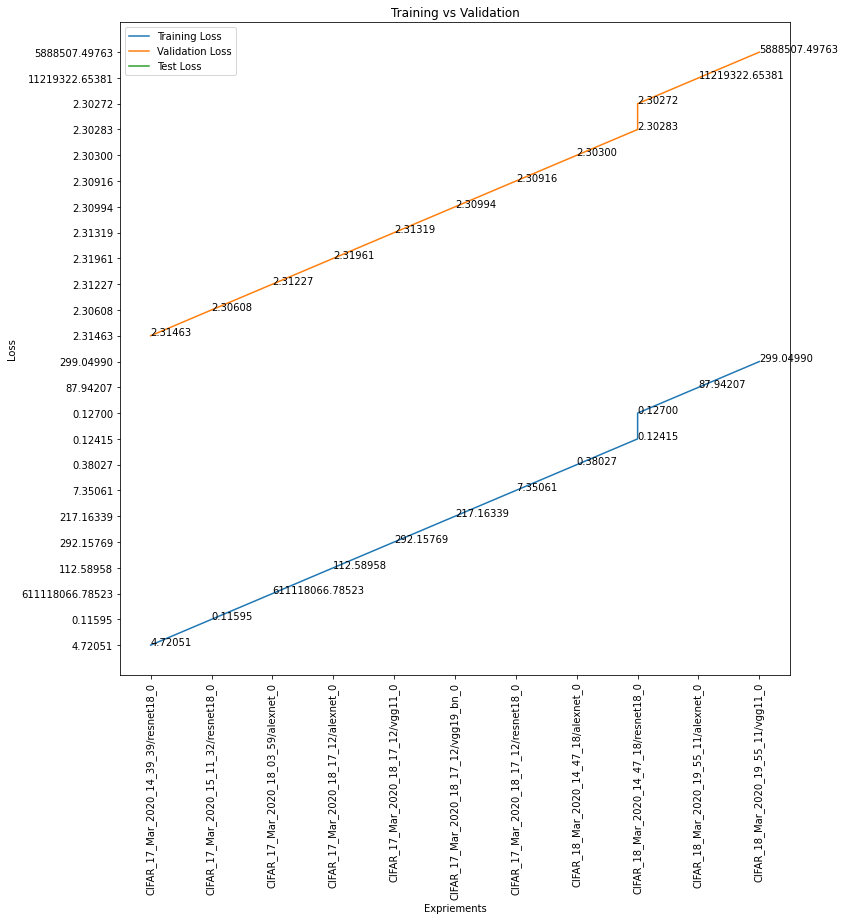

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Start Global Counter: 0 Network Type:alexnet EXP-ID:19_Mar_2020_16_01_18  DurationSinceStart : 0:00:05.799329  with hidden_layers: 2  hidden_layer_width: (2048, 2048)  Learning_Rate: 0.1  drop_ratio: 0.8
CUDA is available!  Using GPU ...
19_Mar_2020_16_01_24 : Starting Training using Model Parameters 
 Network(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (

In [0]:
tune_train_network('CIFAR',3,resumeExp=False,resume_logPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/logs/test.txt',resume_checkpointPath='/content/gdrive/My Drive/Colab Notebooks/models/CIFAR/test/',network_type='resnet18')


In [0]:

""",'vgg11'-> model.classifier[0].in_features
'vgg11_bn'-> model.classifier[0].in_features
'vgg13' -> model.classifier[0].in_features
'vgg13_bn'-> model.classifier[0].in_features

'vgg16','vgg16_bn','vgg19','vgg19_bn',
                             'resnet18' ->model.fc.in_features
                             
                             ,'resnet34','resnet50','resnet101','resnet152',
                             'squeezenet1_0','squeezenet1_1', -> 512

                             'densenet121','densenet169','densenet161','densenet201', -> model.classifier.in_features
                             'inception_v3'
                            ]

"""
#model  = pretrained_models.densenet121(pretrained=True)
#print(model)
#print(model.classifier.in_features)

def test_pre_trained_mode():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_loader , valid_loader ,test_loader , classes , transform = LoadData('CIFAR',20,0.2,'resnet18')

  model = pretrained_models.resnet18(pretrained=True)

  print(model)
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
      param.requires_grad = False
      
  model.classifier = nn.Sequential(nn.Linear(512, 1024),
                                  nn.ReLU(),
                                  nn.Dropout(0.2),
                                  nn.Linear(1024, 10),
                                  nn.LogSoftmax(dim=1))

  criterion = nn.NLLLoss()

  # Only train the classifier parameters, feature parameters are frozen
  optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

  model.to(device);

  epochs = 1
  steps = 0
  running_loss = 0
  print_every = 2
  for epoch in range(epochs):
      for inputs, labels in train_loader:
          steps += 1
          # Move input and label tensors to the default device
          inputs, labels = inputs.to(device), labels.to(device)
          
          optimizer.zero_grad()
          logps = model.forward(inputs)
          loss = criterion(logps, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          
          if steps % print_every == 0:
              test_loss = 0
              accuracy = 0
              model.eval()
              with torch.no_grad():
                  for inputs, labels in test_loader:
                      inputs, labels = inputs.to(device), labels.to(device)
                      logps = model.forward(inputs)
                      batch_loss = criterion(logps, labels)
                      
                      test_loss += batch_loss.item()
                      
                      # Calculate accuracy
                      ps = torch.exp(logps)
                      top_p, top_class = ps.topk(1, dim=1)
                      equals = top_class == labels.view(*top_class.shape)
                      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                      
              print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(test_loader):.3f}.. "
                    f"Test accuracy: {accuracy/len(test_loader):.3f}")
              running_loss = 0
              model.train()